In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from collections import Counter, defaultdict
import csv
import itertools as it
import pandas as pd
import researchpy as rp
import scipy
import seaborn as sns
sns.set()

DATAFILE="./data/acl-parscit.csv"

In [2]:
VENUES = {
    'D': 'EMNLP',
    'E': 'EACL',
    'J': 'CL',
    'N': 'NAACL',
    'K': 'CoNLL',
    'P': 'ACL',
    'Q': 'TACL',
}

def parse_csv_to_pandas(filename):
    '''
    A custom CSV parsing function to process the data in the Marcel format
    '''
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        df = defaultdict(list)
        
        for row in reader:
            paper_id = row[0]
            paper_venue = paper_id[0]
            year = int(row[1])
            citations = row[2].split(',')
            if len(citations) <= 1:
                # Front matter or articles that otherwise failed to parse any citations
                continue
            citations = [int(x) for x in citations]
            ages = [year - x for x in citations if x <= year]

            for a in ages:
                df['paper_id'].append(paper_id)
                df['venue'].append(VENUES.get(paper_venue, paper_venue))
                df['year'].append(year)
                df['cited_age'].append(a)
        
    return pd.DataFrame.from_dict(df)

# ACL Dataset — basic stats

We're using a dataset that only contains long and short papers from the main conferences and journals.

In [3]:
df = parse_csv_to_pandas(DATAFILE)

For the record, these are the exact ACL ID prefixes contained in this dataset:

In [4]:
df['paper_id'].apply(lambda x: x[:5]).unique()

array(['D10-1', 'D11-1', 'D12-1', 'D13-1', 'D14-1', 'D15-1', 'D16-1',
       'D17-1', 'D18-1', 'E12-1', 'E14-1', 'E14-4', 'E17-1', 'E17-2',
       'J10-1', 'J10-2', 'J10-3', 'J10-4', 'J11-1', 'J11-2', 'J11-3',
       'J11-4', 'J12-1', 'J12-2', 'J12-3', 'J12-4', 'J13-1', 'J13-2',
       'J13-3', 'J13-4', 'J14-1', 'J14-2', 'J14-3', 'J14-4', 'J15-1',
       'J15-2', 'J15-3', 'J15-4', 'J16-1', 'J16-2', 'J16-3', 'J16-4',
       'J17-1', 'J17-2', 'J17-3', 'J17-4', 'J18-1', 'J18-2', 'J18-3',
       'J18-4', 'J19-1', 'N10-1', 'N12-1', 'N13-1', 'N15-1', 'N16-1',
       'N18-1', 'N18-2', 'N19-1', 'P10-1', 'P10-2', 'P11-1', 'P11-2',
       'P12-1', 'P12-2', 'P13-1', 'P13-2', 'P14-1', 'P14-2', 'P15-1',
       'P15-2', 'P16-1', 'P16-2', 'P17-1', 'P17-2', 'P18-1', 'P18-2',
       'Q13-1', 'Q14-1', 'Q15-1', 'Q16-1', 'Q17-1', 'Q18-1', 'Q19-1'],
      dtype=object)

We want to **reserve the years 2018 & 2019** for additional experiments, so let's remove them for now.

In [5]:
df = df[df['year'] < 2018]

Let's plot the **number of papers per year** in our dataset, as well as the **venues** they're coming from:

<IPython.core.display.Javascript object>


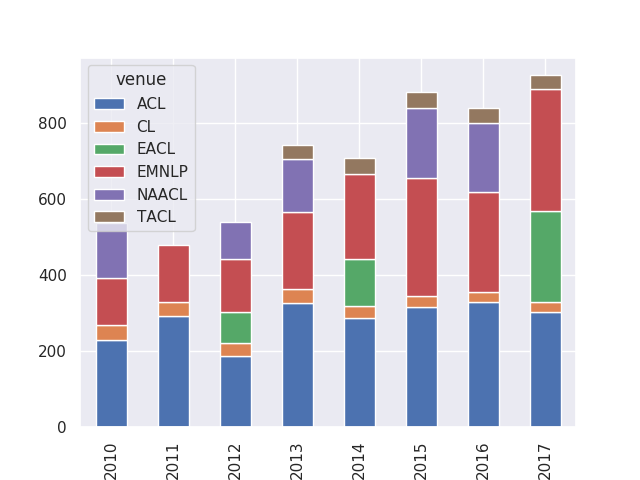

In [6]:
pivot = df.groupby(['year', 'venue'])['paper_id'].nunique().reset_index().pivot(index='year', columns='venue', values='paper_id')
pivot.plot.bar(stacked=True)

Before we look at the actual citations, let's **filter out**

- citations from the future, and
- citations older than 50 years.

In [7]:
df = df[df['cited_age'] >= 0]
df = df[df['cited_age'] <= 50]

Plot the distribution of citation age by year:

<IPython.core.display.Javascript object>


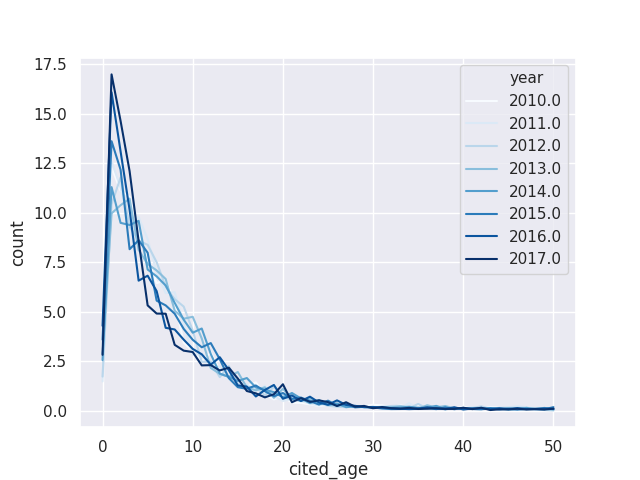

In [23]:
# Count citations by year & cited_age
counts = df.groupby(['year', 'cited_age']).count()
counts = counts.reset_index().filter(items=['year', 'cited_age', 'venue'])
counts.columns.values[-1] = "count"

# Normalize by total no. of citations in year
nfactor = df.groupby(['year']).count().reset_index()
counts['count'] = counts['count'].astype(float)
ncounts = counts.apply(lambda x: [x[0], x[1], (100 * x[2] / float(nfactor[nfactor['year']==x[0]]['paper_id']))], axis=1, result_type='broadcast')

sns.lineplot(data=ncounts, x='cited_age', y='count', hue='year', legend='full', palette='Blues')

## Q1 (Recency): Is there a tendency for newer papers to cite more recently published papers?

We want to look at the age of citations by year.  Let's see a box plot of this distribution, which shows the quantiles of the age data:

<IPython.core.display.Javascript object>


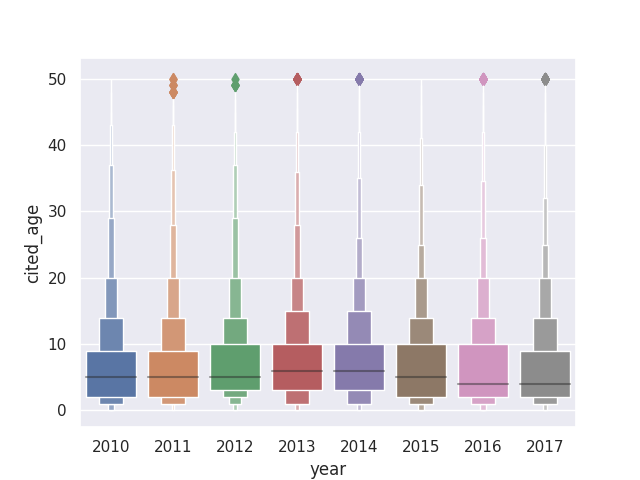

In [15]:
sns.boxenplot(data=df, x='year', y='cited_age')

It is hard to infer something from this plot (and standard `boxplot` or `violinplot` are even worse IMHO). The main quantile for 2017 looks similar to 2010/2011, although the median bar goes down from 2014 to 2016.

Let's see some numerical stats about the citation age:

In [21]:
rp.summary_cont(df['cited_age'].groupby(df['year']))

,N,Mean,SD,SE,95% Conf.,Interval
year,,,,,,
2010,12919,7.272002,7.694207,0.067694,7.139317,7.404688
2011,12662,7.379087,7.613379,0.067659,7.246470,7.511704
2012,14679,7.631242,7.633068,0.063001,7.507755,7.754729
2013,21363,7.691008,7.625360,0.052171,7.588750,7.793265
2014,21208,7.664230,7.478259,0.051351,7.563580,7.764881
2015,25616,7.211235,7.407500,0.046282,7.120520,7.301950
2016,26465,7.000302,7.638855,0.046956,6.908267,7.092338
2017,30511,6.691718,7.424163,0.042503,6.608411,6.775025


There is a downwards trend in the mean from 2013 onwards; however, the means in 2011/2012 were also lower than in 2013.

Let's first look at **whether the differences are statistically significant** at all.  We'll use the non-parametric [Kruskal-Wallis test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) with a significance level of $p \leq 0.005$.

In [26]:
all_years = df['year'].unique()
df_by_year = [df['cited_age'][df['year'] == year] for year in all_years]
scipy.stats.kruskal(*df_by_year)

KruskalResult(statistic=1230.5906303331838, pvalue=1.7121349194308757e-261)

Running post-hoc tests to detect which pairs of publication years significantly differ from each other.  This is done using Mann-Whitney tests with Bonferroni correction.

In [68]:
p_t = 0.005 / len(list(it.combinations(all_years, 2)))

mw_table = defaultdict(list)
for a, b in it.combinations(all_years, 2):
    data_a = df['cited_age'][df['year']==a]
    data_b = df['cited_age'][df['year']==b]
    test = scipy.stats.mannwhitneyu(data_a, data_b, alternative='two-sided')
    mw_table['year_a'].extend([a,b])
    mw_table['year_b'].extend([b,a])
    mw_table['p_val'].extend([test.pvalue] * 2)
    mw_table['stat'].extend([test.statistic] * 2)
    mw_table['significance'].extend([test.pvalue < p_t] * 2)

mw_table = pd.DataFrame.from_dict(mw_table)
mw_table.pivot('year_a', 'year_b', 'significance')

year_b,2010,2011,2012,2013,2014,2015,2016,2017
year_a,,,,,,,,
2010,NaN,False,True,True,True,False,True,True
2011,False,NaN,True,True,True,False,True,True
2012,True,True,NaN,False,False,True,True,True
2013,True,True,False,NaN,False,True,True,True
2014,True,True,False,False,NaN,True,True,True
2015,False,False,True,True,True,NaN,True,True
2016,True,True,True,True,True,True,NaN,True
2017,True,True,True,True,True,True,True,NaN


So the distribution of citation ages in 2017 is significantly different compared to all years before; the same is true for 2016.  As their medians and/or main quantile ranges are lower, we can infer that more recently published papers are cited compared to the years before.  However, in the same way, the distribution in 2012 is significantly different from 2010 and 2011; in that case, papers in 2012 cited more *older* papers compared to 2010/2011.

What's the **effect size** of these differences?

I had a somewhat hard time figuring out an appropriate calculation for the Mann-Whitney, but think that [common language effect size (CLES)](https://en.wikipedia.org/wiki/Effect_size#Common_language_effect_size) might be an appropriate measure.  (It can be converted into a *rank-biserial correlation*, which was introduced particularly as an effect size measure for the Mann-Whitney test.)

In [42]:
def cles(group_a, group_b):
    """Common language effect size.
    
    Returns the probability that a random draw from group_b is 
    *greater* than a random draw from group_a.
    """
    group_a, group_b = sorted(group_a), sorted(group_b)
    num, idx = 0, 0
    for b in group_b:
        while idx < len(group_a) and group_a[idx] < b:
            idx += 1
        num += idx  # number of observations in group_a that are < b
    return num / (len(group_a) * len(group_b))

In [63]:
calculate_cles = lambda r: cles(df['cited_age'][df['year']==r[0]],
                                df['cited_age'][df['year']==r[1]])
mw_table['cles'] = mw_table.filter(['year_a', 'year_b']).apply(calculate_cles, axis=1)
mw_table.pivot('year_a', 'year_b', 'cles')

year_b,2010,2011,2012,2013,2014,2015,2016,2017
year_a,,,,,,,,
2010,NaN,0.474870,0.491009,0.493537,0.494535,0.464198,0.439184,0.422226
2011,0.454160,NaN,0.480755,0.483833,0.484570,0.453968,0.428947,0.411351
2012,0.440406,0.449704,NaN,0.469696,0.470810,0.440756,0.416508,0.399013
2013,0.439355,0.448738,0.464392,NaN,0.469104,0.440025,0.416186,0.399086
2014,0.438275,0.447539,0.463445,0.466451,NaN,0.438990,0.415630,0.398531
2015,0.466071,0.475641,0.491375,0.494043,0.494566,NaN,0.441387,0.425758
2016,0.488929,0.498941,0.514205,0.516201,0.516591,0.486216,NaN,0.447704
2017,0.501933,0.512845,0.528358,0.529949,0.530338,0.498394,0.471767,NaN


In the table above, each cell gives the probability that a randomly drawn citation from `year_b` will be *older* than a randomly drawn citation from `year_a`.

For example, there is a 53.03% probability that a citation from 2014 will be older than one from 2017.  However, the probability is only 50.19% for 2010 vs. 2017, almost equal to chance.  And a citation from 2016 is only older than one from 2017 in 47.18% of cases.

## Q2: Are older papers being forgotten?

We are trying to answer this question by answering the following:

+ **Are papers older than *N* years still being cited at the same rate now compared to then?**

<IPython.core.display.Javascript object>


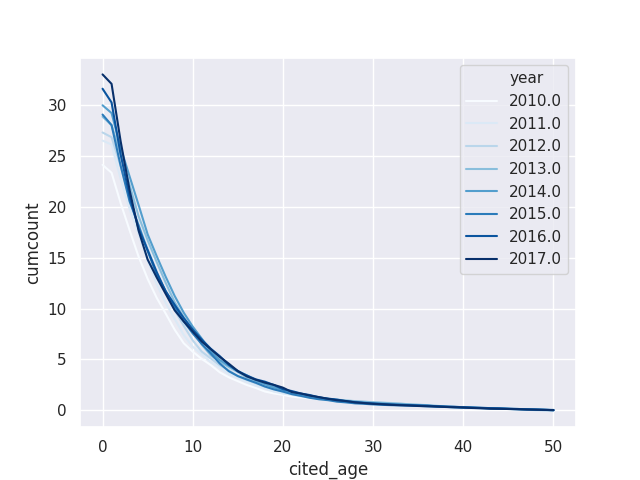

In [71]:
# normalize by total no. of *papers* in year
pfactor = df['paper_id'].groupby(df['year']).nunique('paper_id').reset_index()
counts['count'] = counts['count'].astype(float)
pcounts = counts.apply(lambda x: [x[0], x[1], x[2] / float(pfactor[pfactor['year']==x[0]]['paper_id'])], axis=1, result_type='broadcast')

# cumulative count of citations of age X or older
# need to reverse first so we start from the oldest...
pcounts = pcounts.sort_values(by='cited_age', ascending=False)
# then cumulatively sum up, for each year individually
pcounts['cumcount'] = pcounts.groupby('year')['count'].transform(pd.Series.cumsum)

sns.lineplot(data=pcounts, x='cited_age', y='cumcount', hue='year', legend='full', palette='Blues')

The graph above shows the **average number of citations per paper that are *X* or more years old**.

At point 0, it shows the average number of cited publications per paper. We can see that in more recent years, papers tend to cite more papers on average.  We can sanity-check that this calculation is correct by directly calculating the average number of citations per paper:

In [88]:
# no. of citations per paper
cpp = df.groupby(['paper_id', 'year']).count()['cited_age'].reset_index()
# mean by year
cpp.groupby('year').mean()

,cited_age
year,
2010,24.102612
2011,26.489540
2012,27.284387
2013,28.829960
2014,29.954802
2015,29.043084
2016,31.581146
2017,32.984865


Considering "older" citations, say, citations for papers that are at least 10 years old, the trend is that they are of course cited way less often, but **there doesn't appear to be a clear trend based on publication year**, giving evidence that they're not forgotten after all.

This can be seen more easily when zooming in on the older citations:

<IPython.core.display.Javascript object>


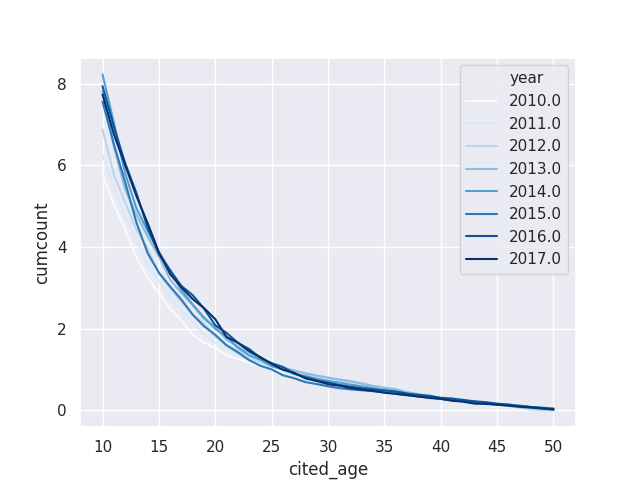

In [89]:
sns.lineplot(data=pcounts[pcounts['cited_age']>=10], x='cited_age', y='cumcount', hue='year', legend='full', palette='Blues')

The following plot considers only the **distribution of the *oldest* citation per publication:**

<IPython.core.display.Javascript object>


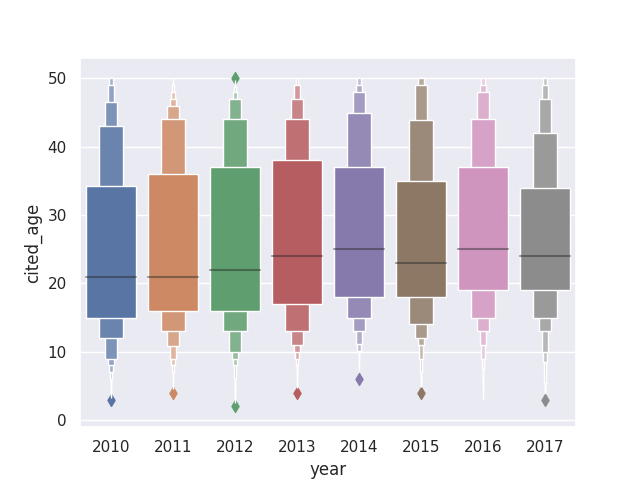

In [90]:
df_max = df.groupby(['paper_id', 'year']).max(level='cited_age').reset_index()
sns.boxenplot(data=df_max, x='year', y='cited_age')